In [4]:
INDEXES = {
    "BI": "((S1 + R) - (N + B))/((S1 + R) + (N + B))",
    "BNDVI": "(N - B)/(N + B)",
    "MGRVI": "(G ** 2.0 - R ** 2.0) / (G ** 2.0 + R ** 2.0)",
    "NDCI": "(RE1 - R)/(RE1 + R)",
    "NLI": "((N ** 2) - R)/((N ** 2) + R)",
}

In [3]:
import torch.nn as nn
from LandcoverDataset import LandcoverDataset as LD
from Model import CNN
from utils import *
from random import choice as c

# Datasets loading into RAM

In [ ]:
BATCH = 4

TRAIN = LD(
    img_path="datasets/USA/train/images/",
    mask_path="datasets/USA/train/masks/",
    batch_size=BATCH,
    indexes=list(INDEXES.values()),
    # n_random=20
)
VALIDATION = LD(
    img_path="datasets/USA/valid/images/",
    mask_path="datasets/USA/valid/masks/",
    batch_size=BATCH,
    transforms=False,
    indexes=list(INDEXES.values()),
    # n_random=5
)
TEST = LD(
    img_path="datasets/Russia/train/images/",
    mask_path="datasets/Russia/train/masks/",
    batch_size=4,
    # transforms=False,
    indexes=list(INDEXES.values()),
    n_random=1000
)

## Some insights about data

In [15]:
image_name, mask_name = TRAIN.rand_samp_names()
print(1, tif_info(image_name))
print(2, tif_info(mask_name))
print(3)
TRAIN.getinfo()

1 
Filename: datasets/USA/train/images/large_22_09.tif
Dimensions: 3D
Shape: (512, 512, 10)
Number of bands: 10
Resolution: None*None None
Data type: uint16
Bit depth: 16
Unique colors per band: [1762, 1786, 1786, 1788, 1770, 1803, 1777, 1768, 1767, 1748]
        
2 
Filename: datasets/USA/train/masks/large_22_09.tif
Dimensions: 2D
Shape: (512, 512)
Number of bands: 1
Resolution: None*None None
Data type: uint8
Bit depth: 8
Unique colors per band: [5]
        
3
Dataset Information:
Number of samples: 20
Image Shape: (15, 512, 512)
Mask Shape: (512, 512)
Image Data Type: float32
Mask Data Type: uint8
Transformations: Compose(
      RandomVerticalFlip(p=0.5)
      RandomHorizontalFlip(p=0.5)
)
Spectral Indices: ['((S1 + R) - (N + B))/((S1 + R) + (N + B))', '(N - B)/(N + B)', '(G ** 2.0 - R ** 2.0) / (G ** 2.0 + R ** 2.0)', '(RE1 - R)/(RE1 + R)', '((N ** 2) - R)/((N ** 2) + R)']


## Just look at it

In [ ]:
TRAIN.plot_sample(90)

In [ ]:
TRAIN.plot_sample(90,index="((N ** 2) - R)/((N ** 2) + R)")

In [ ]:
TRAIN.plot_sample(90,index="(G ** 2.0 - R ** 2.0) / (G ** 2.0 + R ** 2.0)")

# The model

In [ ]:
INPUT_CHANNELS = 10 + len(INDEXES)
N_CLASSES = 5

model = CNN([
    nn.Conv2d(INPUT_CHANNELS, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, N_CLASSES, kernel_size=1),
    nn.Upsample(size=(512, 512), mode='nearest')
])

## Hyperparameters

In [ ]:
learning_rate = 0.002
n_epochs = 15
saving_threshold = 0.51

## Start training

In [ ]:
model.train(TRAIN, VALIDATION, n_epochs, learning_rate, saving_threshold)

## Give it a name and pickle it

In [ ]:
modelname = f"lr={learning_rate},n_epochs={n_epochs},thres={saving_threshold}"
nodel.pickle(f"models/{modelname}.torch")

In [ ]:
model.unpickle(f"models/{modelname}.torch")

## Here is the training story (pickles alongside the model)

In [ ]:
model.plot_training_history()

In [ ]:
dl_test = LD(
    img_path="datasets/TEST/test/images/",
    mask_path="datasets/TEST/test/masks/",
    batch_size=4,
    transforms=False,
    indexes=list(INDEXES.values()),
    # n_random=10
)

In [ ]:
from random import choice as c
dl_test.plot_prediction(model, c(range(441)))

# Experiment
Compare performance of a model on a new domain after 1 epoch of training with/without partial weights freezing.

In [ ]:
model_old.unpickle(f"models/BASE_epoch=11,mm=0.5.torch")
test_v = model_old.test(VALIDATION)
test_t = model_old.test(TEST)

model_old.unpickle(f"models/BASE_epoch=11,mm=0.5.torch")
model_old.train(TEST, TEST, 1, 0.001, 2)
test_just = model_old.test(TEST)

model_old.unpickle(f"models/BASE_epoch=11,mm=0.5.torch")
for i, param in enumerate(model_old.model.parameters()):
    if i <= 6:
        param.requires_grad = False
model_old.train(TEST, TEST, 1, 0.001, 2)
test_frozen_0x6 = model_old.test(TEST)

In [ ]:
import json

data = {
    'test_v': test_v,
    'test_t': test_t,
    'test_just': test_just,
    'test_frozen_0x6': test_frozen_0x6,
}

with open('results_new.json', 'w') as f:
    json.dump(data, f, indent=4)
with open('results_new.json', 'r') as f:
    data = json.load(f)

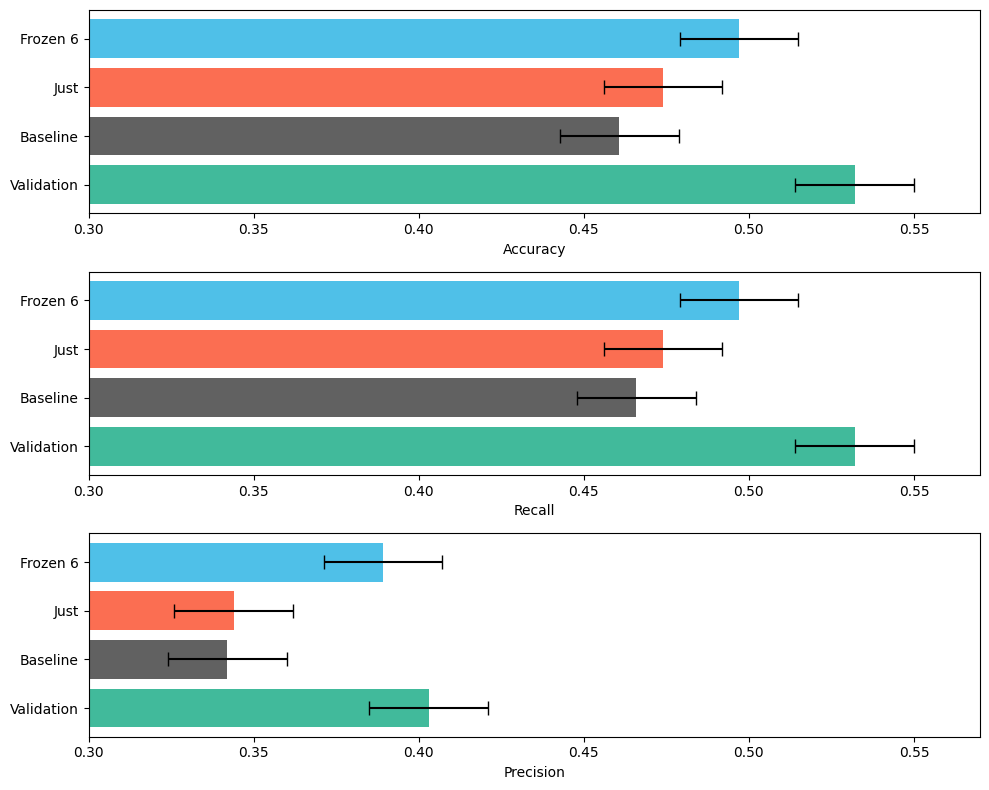

In [37]:
results = [data["test_v"], data["test_t"], data["test_just"], data["test_frozen_0x6"]]
labels = ['Validation', 'Baseline', 'Just', 'Frozen 6']
metrics = ['test_accuracy', 'test_recall', 'test_precision']
colors = ['#41BA9BFF', '#616161FF', '#FB6E52FF', '#4FC0E8FF']
errs = [0.018,0.018,0.018,0.018] # totally absolutely fake confidence intervals

fig, axes = plt.subplots(3, 1, figsize=(10, 8))

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = [result[metric] for result in results]
    cis = errs[i]
    
    ax.barh(labels, values, color=colors, xerr=cis, capsize=5)    
    ax.set_xlim(0.3, 0.57)
    ax.set_xlabel(metric.replace('test_', '').capitalize())
    ax.xaxis.set_major_locator(plt.FixedLocator([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]))

plt.tight_layout()
plt.show()